In [1]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras.optimizers import Adam
import keras.metrics

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

import keras
import keras_tuner as kt

keras.__version__


2025-01-27 12:29:46.974019: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1737977386.984733  138256 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1737977386.987893  138256 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-27 12:29:46.999775: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


'3.8.0'

In [2]:
csv_file_path = 'my_dir/jena_climate_2009_2016_extracted/jena_climate_2009_2016.csv'

if not os.path.exists(csv_file_path):
    zip_path = tf.keras.utils.get_file(
        origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
        fname='jena_climate_2009_2016.csv.zip',
        extract=True
    )
    extracted_dir = os.path.join(os.path.dirname(zip_path), 'jena_climate_2009_2016_extracted')
    extracted_file = os.path.join(extracted_dir, 'jena_climate_2009_2016.csv')
    
    os.makedirs(os.path.dirname(csv_file_path), exist_ok=True)
    os.rename(extracted_file, csv_file_path)
    print(f"Plik został zapisany w lokalizacji: {csv_file_path}")

else:
    print(f"Plik już istnieje: {csv_file_path}")

df = pd.read_csv(csv_file_path)

Plik już istnieje: my_dir/jena_climate_2009_2016_extracted/jena_climate_2009_2016.csv


In [3]:
df.keys()
selected_columns = ['p (mbar)', 'T (degC)', 'rh (%)', 'Tdew (degC)', 'VPmax (mbar)']
target_columns = ['p (mbar)', 'T (degC)', 'rh (%)']

print(df.shape)
df.head()

(420551, 15)


,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


In [4]:
def generator(data, lookback, delay, input_indices, target_indices, min_index, max_index,
              batch_size=128, samples_step=1, targets_step=6):

    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    
    
    while True:
        if i + batch_size >= max_index:
            i = min_index + lookback
        rows = np.arange(i, min(i + batch_size, max_index))
        i += len(rows)

        # Przygotowanie próbek i celów
        samples = np.zeros((len(rows), lookback // samples_step, len(input_indices)))
        targets = np.zeros((len(rows), delay // targets_step, len(target_columns)))
        
        for j, row in enumerate(rows):
            # Indeksy dla próbek i celów
            s_indices = list(range(rows[j] - lookback, rows[j], samples_step))
            t_indices = list(range(rows[j], rows[j] + delay, targets_step))
            
            # Upewnij się, że indeksy nie wykraczają poza zakres
            if max(s_indices) >= len(data) or max(t_indices) >= len(data):
                continue

            # Pobranie próbek i celów
            samples[j] = data[s_indices][:, input_indices]
            targets[j] = data[t_indices][:, target_indices]
        
        yield samples, targets


In [5]:
TRAIN_SPLIT = 330000

#wstepna obrubka danych
data = df.drop(['Date Time'], axis=1)

# Uzyskanie indeksów kolumn
input_indices = [data.columns.get_loc(col) for col in selected_columns]
target_indices = [data.columns.get_loc(col) for col in target_columns]
# Wyświetlenie indeksów
print("Indeksy dla selected_columns:", input_indices)
print("Indeksy dla target_columns:", target_indices)

dataset = data.values

#przygotowanie do normalizacji
data_mean = dataset[:TRAIN_SPLIT].mean(axis=0)
data_std = dataset[:TRAIN_SPLIT].std(axis=0)
dataset = (dataset-data_mean)/data_std

print(data_mean)
print("#############")
print(data_std)

Indeksy dla selected_columns: [0, 1, 4, 3, 5]
Indeksy dla target_columns: [0, 1, 4]
[ 988.80187064    8.92632655  283.00079882    4.55339067   76.48203409
   13.13652715    9.31004185    3.82639936    5.88299973    9.4177223
 1217.93582064    2.151373      3.55671667  174.1361133 ]
#############
[ 8.37526559  8.47974514  8.55663505  6.8792257  16.35201742  7.51162222
  4.17803453  4.66189232  2.65203329  4.2294396  40.31981161  1.54040076
  2.33407965 87.06572617]


In [6]:
#3 dni prubek - 1 na 30min
lookback = 432
s_step = 3
#input_indices 

#24 godziny do przodu - 1 na 60min
t_step = 6
delay = 144
#target_indices

batch_size = 128


train_gen = generator(dataset,
                      lookback=lookback,
                      delay=delay,
                      input_indices=input_indices,
                      target_indices=target_indices,
                      min_index=0,
                      max_index=TRAIN_SPLIT,
                      samples_step=s_step,
                      targets_step=t_step,
                      batch_size=batch_size)
val_gen = generator(dataset,
                      lookback=lookback,
                      delay=delay,
                      input_indices=input_indices,
                      target_indices=target_indices,
                      min_index=TRAIN_SPLIT + 1,
                      max_index=TRAIN_SPLIT + 45275,
                      samples_step=s_step,
                      targets_step=t_step,
                      batch_size=batch_size)
test_gen = generator(dataset,
                      lookback=lookback,
                      delay=delay,
                      input_indices=input_indices,
                      target_indices=target_indices,
                      min_index=TRAIN_SPLIT + 45276,
                      max_index=None,
                      samples_step=s_step,
                      targets_step=t_step,
                      batch_size=batch_size)

# Liczba kroków pobierania danych z obiektu val_gen
# zapewniających przetworzenie całego walidacyjnego zbioru danych.
val_steps = (45276 - lookback) // batch_size

# Liczba kroków pobierania danych z obiektu test_gen,
# przy której przetworzony zostanie cały testowy zbiór danych.
test_steps = (len(dataset) - TRAIN_SPLIT - 45276 -lookback) // batch_size

train_steps = (TRAIN_SPLIT - lookback) // batch_size

print(train_steps, val_steps, test_steps)
samples, targets = next(train_gen)
print(samples.shape, targets.shape)

2574 350 350
(128, 144, 5) (128, 24, 3)


In [7]:
#bazowy model z zajec, do porownania efektow
model_rnn = models.Sequential()
model_rnn.add(layers.LSTM(32, return_sequences=True, input_shape=(None, samples.shape[-1])))
model_rnn.add(layers.LSTM(16))
model_rnn.add(layers.Dense((delay // t_step) * 3)) 
model_rnn.add(layers.Reshape((delay // t_step, 3))) 

model_rnn.compile(optimizer='adam', loss='mae')
model_rnn.summary()

I0000 00:00:1737977403.574793  138256 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9862 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060, pci bus id: 0000:09:00.0, compute capability: 8.6
/home/krzysztof/my-jupyter/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, None, 32)       │         4,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 16)             │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 72)             │         1,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 24, 3)          │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,224 (36.03 KB)

 Trainable params: 9,224 (36.03 KB)

 Non-trainable params: 0 (0.00 B)

In [8]:
history = model_rnn.fit(train_gen,
                    steps_per_epoch=train_steps,
                    epochs=20,
                    validation_data=val_gen,
                    validation_steps=val_steps)

Epoch 1/20


I0000 00:00:1737906228.818820   85873 cuda_dnn.cc:529] Loaded cuDNN version 90300


2574/2574 ━━━━━━━━━━━━━━━━━━━━ 30s 11ms/step - loss: 0.6189 - val_loss: 0.4849
Epoch 2/20
2574/2574 ━━━━━━━━━━━━━━━━━━━━ 28s 11ms/step - loss: 0.4138 - val_loss: 0.4304
Epoch 3/20
2574/2574 ━━━━━━━━━━━━━━━━━━━━ 28s 11ms/step - loss: 0.3624 - val_loss: 0.4078
Epoch 4/20
2574/2574 ━━━━━━━━━━━━━━━━━━━━ 28s 11ms/step - loss: 0.3507 - val_loss: 0.3990
Epoch 5/20
2574/2574 ━━━━━━━━━━━━━━━━━━━━ 28s 11ms/step - loss: 0.3436 - val_loss: 0.3929
Epoch 6/20
2574/2574 ━━━━━━━━━━━━━━━━━━━━ 28s 11ms/step - loss: 0.3387 - val_loss: 0.3891
Epoch 7/20
2574/2574 ━━━━━━━━━━━━━━━━━━━━ 28s 11ms/step - loss: 0.3351 - val_loss: 0.3837
Epoch 8/20
2574/2574 ━━━━━━━━━━━━━━━━━━━━ 27s 10ms/step - loss: 0.3317 - val_loss: 0.3815
Epoch 9/20
2574/2574 ━━━━━━━━━━━━━━━━━━━━ 28s 11ms/step - loss: 0.3286 - val_loss: 0.3791
Epoch 10/20
2574/2574 ━━━━━━━━━━━━━━━━━━━━ 28s 11ms/step - loss: 0.3259 - val_loss: 0.3769
Epoch 11/20
2574/2574 ━━━━━━━━━━━━━━━━━━━━ 28s 11ms/step - loss: 0.3236 - val_loss: 0.3762
Epoch 12/20
2574/25

Wykorzystanie Transformerow

In [14]:
class PositionalEncodingLayer(layers.Layer):
    def __init__(self, sequence_length, d_model, **kwargs):
        super(PositionalEncodingLayer, self).__init__(**kwargs)
        self.sequence_length = sequence_length
        self.d_model = d_model
        self.pos_encoding = self.compute_positional_encoding()

    def compute_positional_encoding(self):
        positions = np.arange(self.sequence_length)[:, np.newaxis]
        dimensions = np.arange(self.d_model)[np.newaxis, :]
        angle_rates = 1 / np.power(10000, (2 * (dimensions // 2)) / np.float32(self.d_model))
        angle_rads = positions * angle_rates

        # Sinus i cosinus
        angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
        angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
        return tf.constant(angle_rads[np.newaxis, ...], dtype=tf.float32)

    def call(self, inputs):
        seq_len = tf.shape(inputs)[1]
        return inputs + self.pos_encoding[:, :seq_len, :]

def build_transformer_block(inputs, transformer_hp, i):
    # Parametry bloku
    atention_num_heads = transformer_hp.Int(f'atention_num_heads_{i}', min_value=8, max_value=16, step=4)
    atention_dropout_rate = transformer_hp.Float(f'atention_dropout_rate_{i}', min_value=0.0, max_value=0.4, step=0.1)
    key_dim = inputs.shape[-1]

    ffn_type = transformer_hp.Choice(f'ffn_type_{i}', ['Dense', 'Conv1D'])
    ffn_dim_power = transformer_hp.Int(f'ffn_dim_power_{i}', min_value=4, max_value=7, step=1)
    conv_kernel_size = transformer_hp.Int(f'conv_kernel_size_{i}', min_value=3, max_value=5, step=1)
    ffn_activation = transformer_hp.Choice(f'ffn_activation_{i}', ['relu', 'leaky_relu', 'swish'])

    ffn_dropout_rate = transformer_hp.Float(f'ffn_dropout_rate_{i}', min_value=0.0, max_value=0.5, step=0.1)
    
    # Attention
    attention_output = layers.MultiHeadAttention(num_heads=atention_num_heads, key_dim=key_dim)(inputs, inputs)
    attention_output = layers.Dropout(atention_dropout_rate)(attention_output)
    attention_output = layers.Add()([inputs, attention_output])  # Residual connection
    attention_output = layers.LayerNormalization(epsilon=1e-6)(attention_output)

    # FFN - wybór typu warstwy
    if ffn_type == "Dense":
        ffn_output = layers.Dense(2 ** (ffn_dim_power + 2), activation=ffn_activation)(attention_output)
    elif ffn_type == "Conv1D":
        ffn_output = layers.Conv1D(filters=2 ** ffn_dim_power, kernel_size=conv_kernel_size, activation=ffn_activation, padding='same')(attention_output)

    ffn_output = layers.Dropout(ffn_dropout_rate)(ffn_output)
    ffn_output = layers.Dense(key_dim)(ffn_output)  # Dopasowanie wymiaru
    ffn_output = layers.Add()([attention_output, ffn_output])  # Residual connection
    ffn_output = layers.LayerNormalization(epsilon=1e-6)(ffn_output)

    return ffn_output

def build_model_for_transformer_tuning(transformer_hp):
    transformer_dim_power = transformer_hp.Int('transformer_dim_power', min_value=3, max_value=6, step=1)
    transformer_dim = 2 ** transformer_dim_power  # Wymiar transformera
    num_transformer_blocks = transformer_hp.Int('num_transformer_blocks', min_value=1, max_value=3, step=1)

    inputs = layers.Input(shape=(None, samples.shape[-1]))
    x = layers.Dense(transformer_dim)(inputs) 
    x = PositionalEncodingLayer(sequence_length=samples.shape[1], d_model=transformer_dim)(x)  
    
    for i in range(num_transformer_blocks):
        x = build_transformer_block(x, transformer_hp, i)

    x = layers.GlobalAveragePooling1D()(x)
    outputs = layers.Dense((delay // t_step) * 3)(x)  
    outputs = layers.Reshape((delay // t_step, 3))(outputs) # Wyjście dla regresji


    model = models.Model(inputs, outputs)
    model.compile(optimizer='adam', loss='mae')

    return model

In [10]:
tuner = kt.BayesianOptimization(
        build_model_for_transformer_tuning,
        objective='val_loss',
        max_trials=40,  # Maksymalna liczba prób
        executions_per_trial=1, 
        directory='my_dir',
        project_name='transformer_bayes'
    )

tuner.search(
    train_gen,
    epochs=25,
    validation_data=val_gen,
    steps_per_epoch=train_steps,
    validation_steps=val_steps
)

Reloading Tuner from my_dir/transformer_bayes/tuner0.json


In [11]:
best_hps = tuner.get_best_hyperparameters(num_trials=3)
model = build_model_for_transformer_tuning(best_hps[0])

In [12]:
history1 = model.fit(
    train_gen,  # Generator treningowy
    steps_per_epoch=train_steps,
    epochs=20,
    validation_data=val_gen, 
    validation_steps=val_steps
)

Epoch 1/20


I0000 00:00:1737906784.645309   85871 service.cc:148] XLA service 0x778148003cc0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1737906784.645329   85871 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2025-01-26 16:53:04.700481: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-01-26 16:53:05.511792: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_11', 16 bytes spill stores, 16 bytes spill loads

2025-01-26 16:53:05.627726: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_28', 16 bytes spill stores, 16 bytes spill loads

2025-01-26 16:53:06.041707: I external/local_xla/

  13/2574 ━━━━━━━━━━━━━━━━━━━━ 33s 13ms/step - loss: 1.2503

I0000 00:00:1737906789.588372   85871 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2574/2574 ━━━━━━━━━━━━━━━━━━━━ 43s 14ms/step - loss: 0.6140 - val_loss: 0.4850
Epoch 2/20
2574/2574 ━━━━━━━━━━━━━━━━━━━━ 36s 14ms/step - loss: 0.4144 - val_loss: 0.4533
Epoch 3/20
2574/2574 ━━━━━━━━━━━━━━━━━━━━ 40s 15ms/step - loss: 0.3746 - val_loss: 0.4508
Epoch 4/20
2574/2574 ━━━━━━━━━━━━━━━━━━━━ 40s 16ms/step - loss: 0.3613 - val_loss: 0.4652
Epoch 5/20
2574/2574 ━━━━━━━━━━━━━━━━━━━━ 39s 15ms/step - loss: 0.3536 - val_loss: 0.4806
Epoch 6/20
2574/2574 ━━━━━━━━━━━━━━━━━━━━ 40s 15ms/step - loss: 0.3483 - val_loss: 0.4892
Epoch 7/20
2574/2574 ━━━━━━━━━━━━━━━━━━━━ 39s 15ms/step - loss: 0.3442 - val_loss: 0.4951
Epoch 8/20
2574/2574 ━━━━━━━━━━━━━━━━━━━━ 39s 15ms/step - loss: 0.3413 - val_loss: 0.4984
Epoch 9/20
2574/2574 ━━━━━━━━━━━━━━━━━━━━ 39s 15ms/step - loss: 0.3389 - val_loss: 0.5019
Epoch 10/20
2574/2574 ━━━━━━━━━━━━━━━━━━━━ 39s 15ms/step - loss: 0.3370 - val_loss: 0.5032
Epoch 11/20
2574/2574 ━━━━━━━━━━━━━━━━━━━━ 39s 15ms/step - loss: 0.3353 - val_loss: 0.5050
Epoch 12/20
2574/25

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


2025-01-26 17:05:44.327299: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_11', 16 bytes spill stores, 16 bytes spill loads

2025-01-26 17:05:44.413339: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_11', 8 bytes spill stores, 8 bytes spill loads



4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


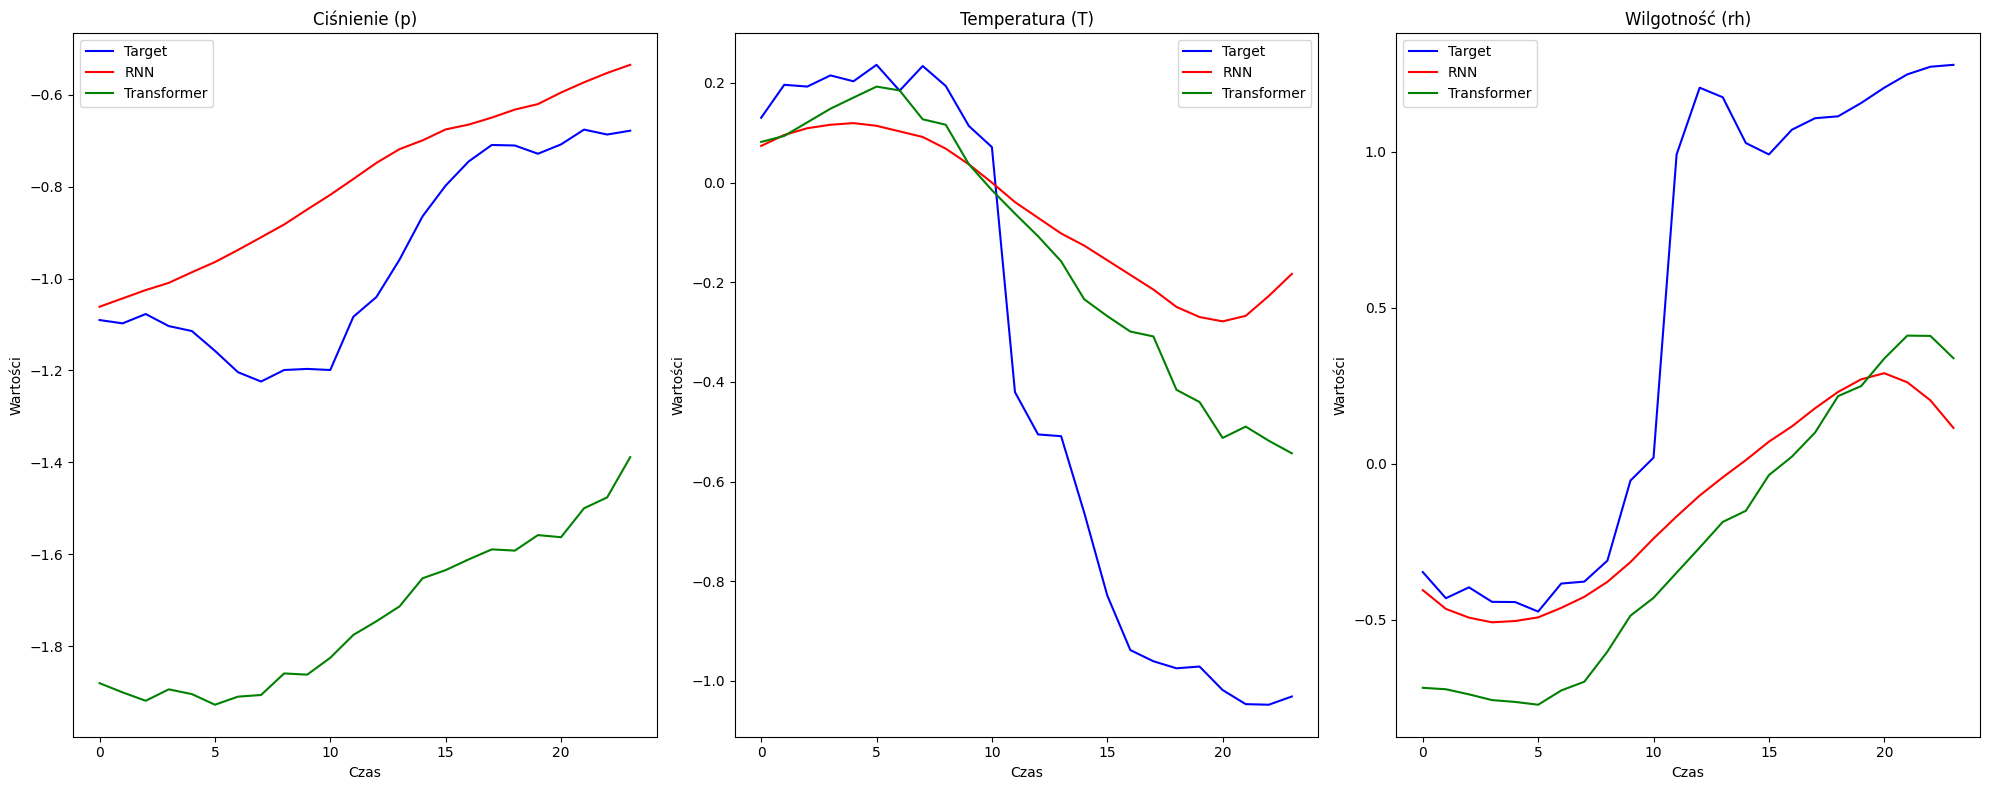

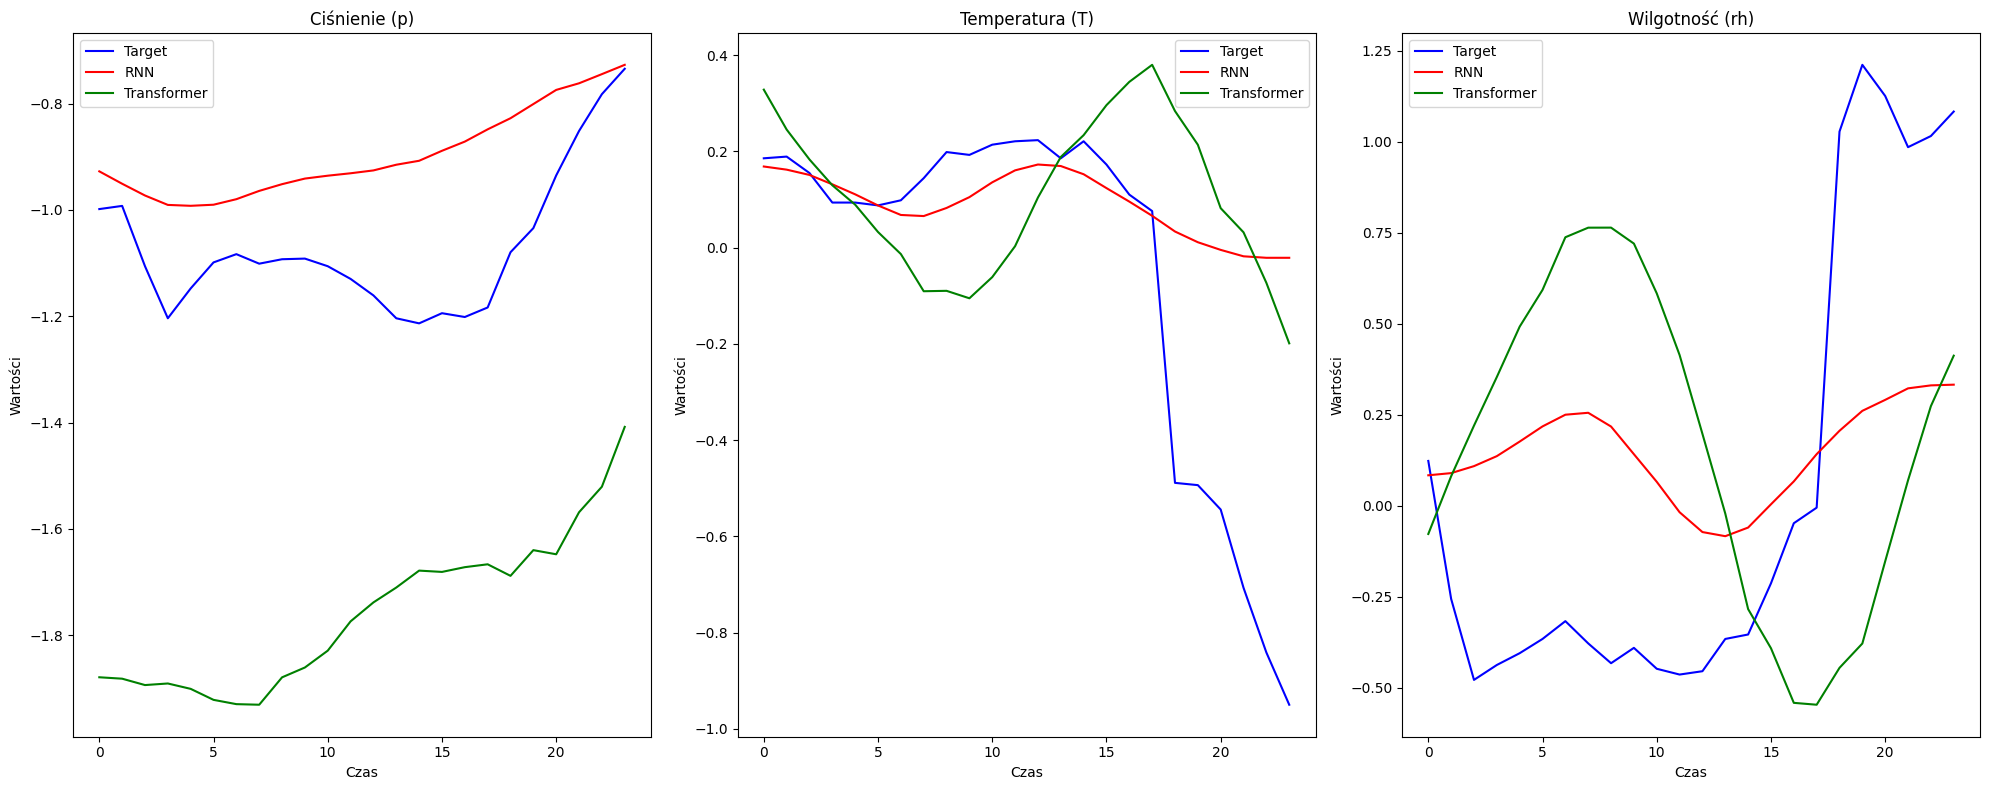

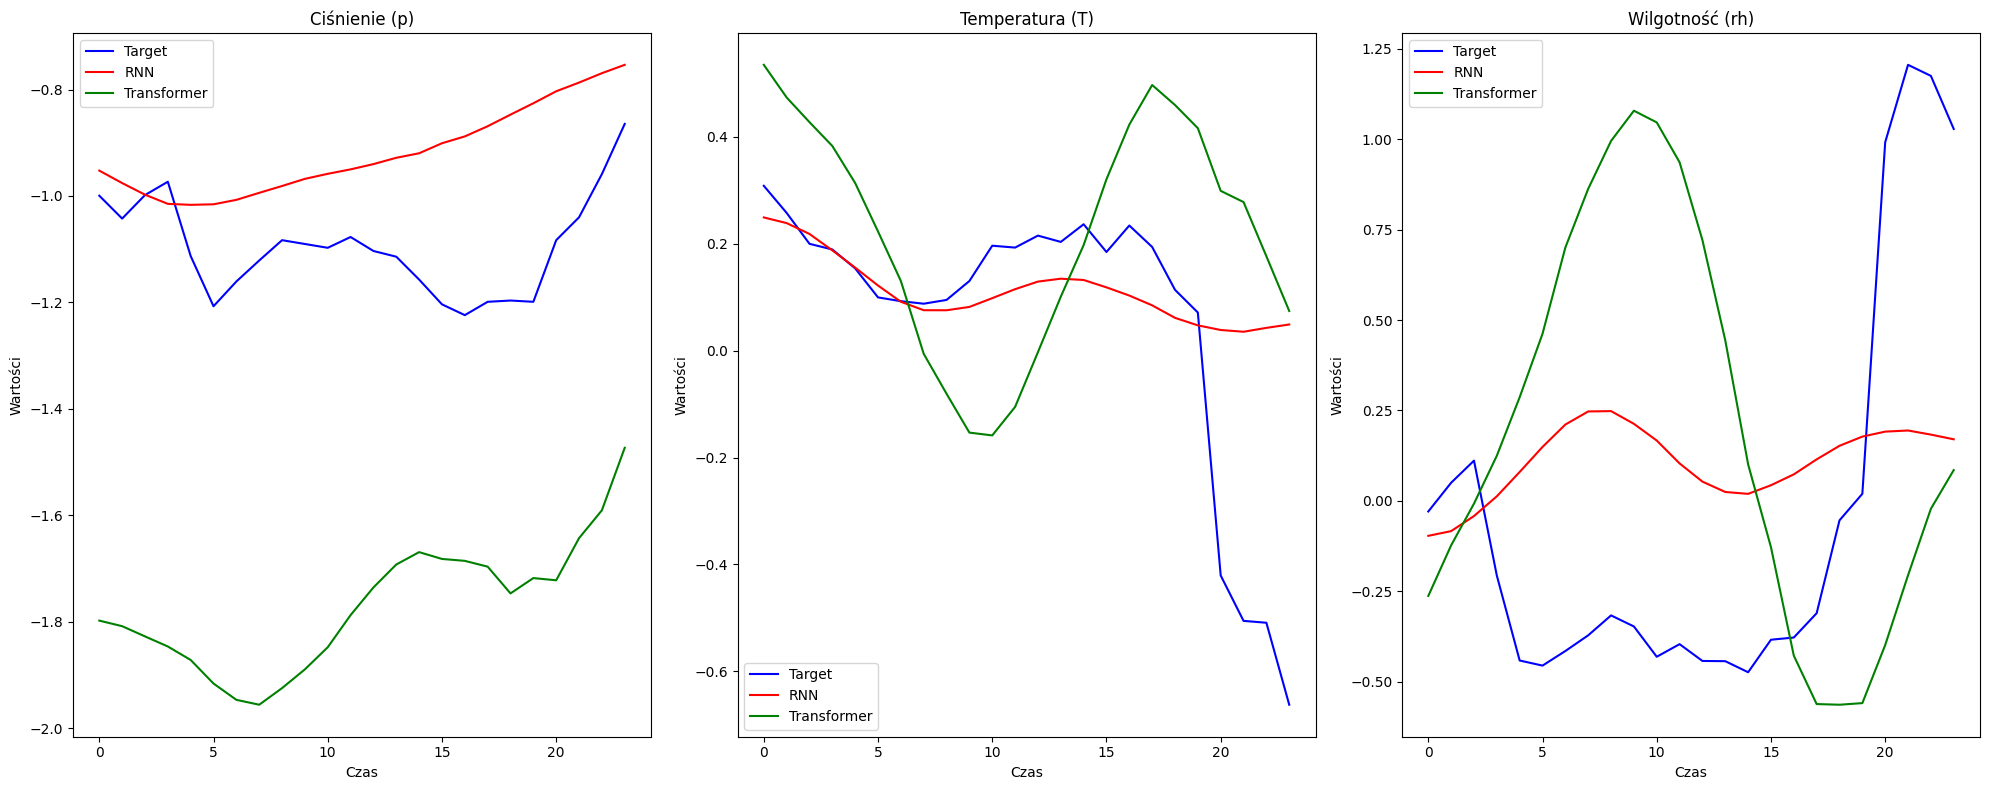

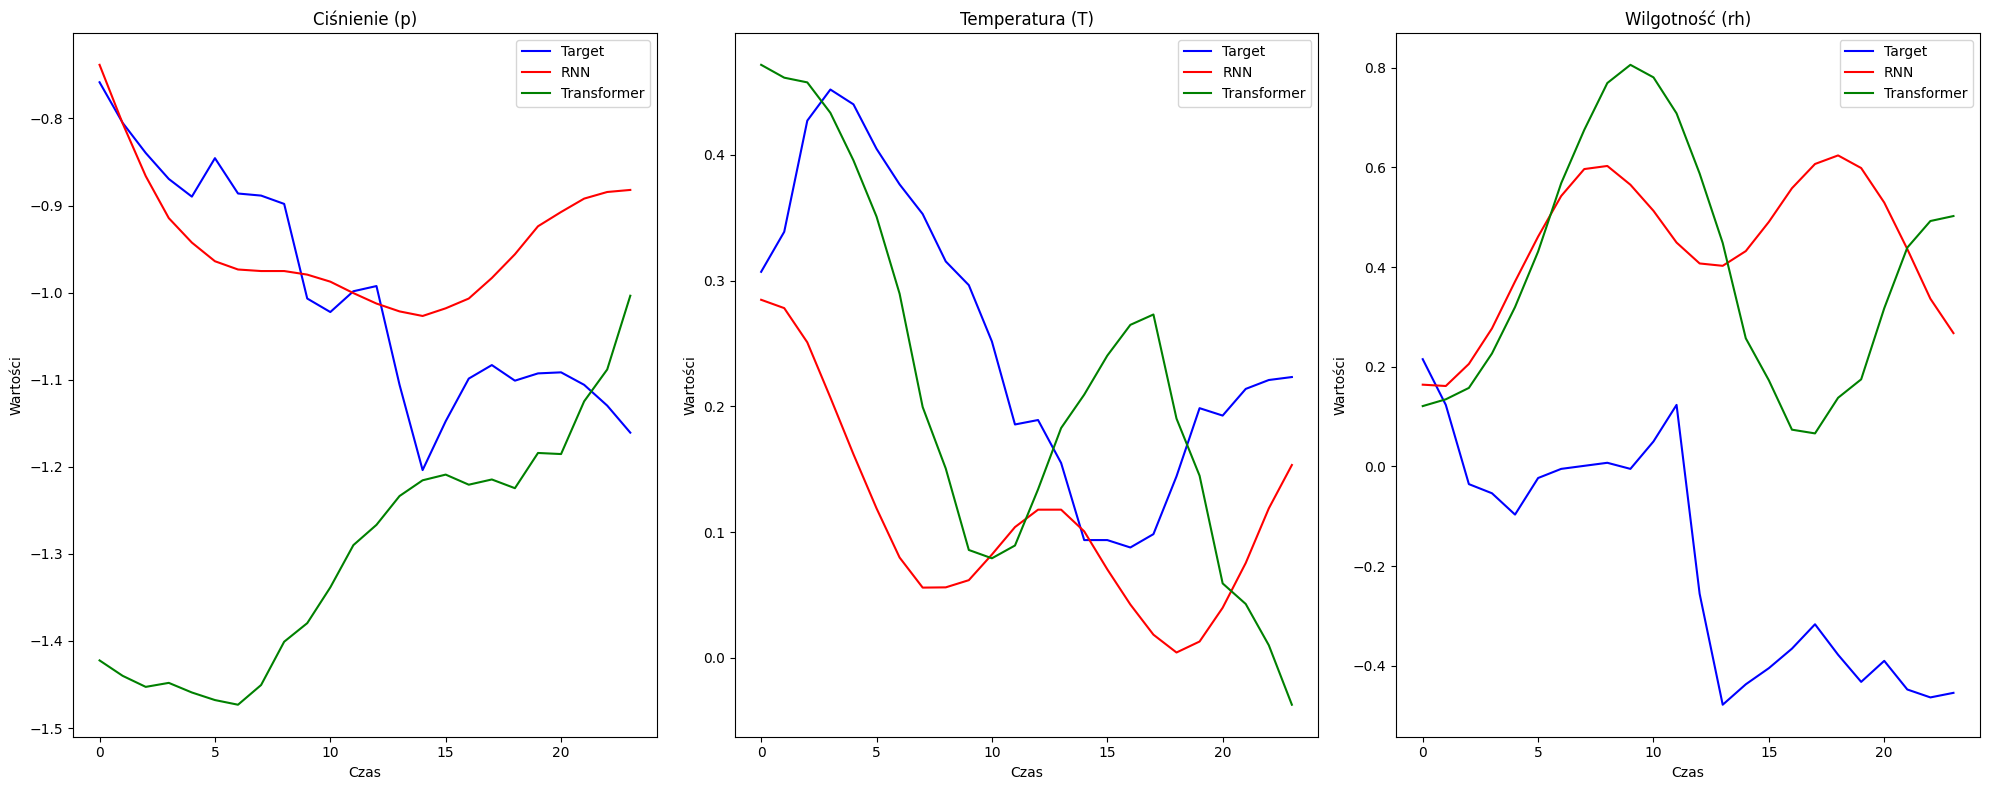

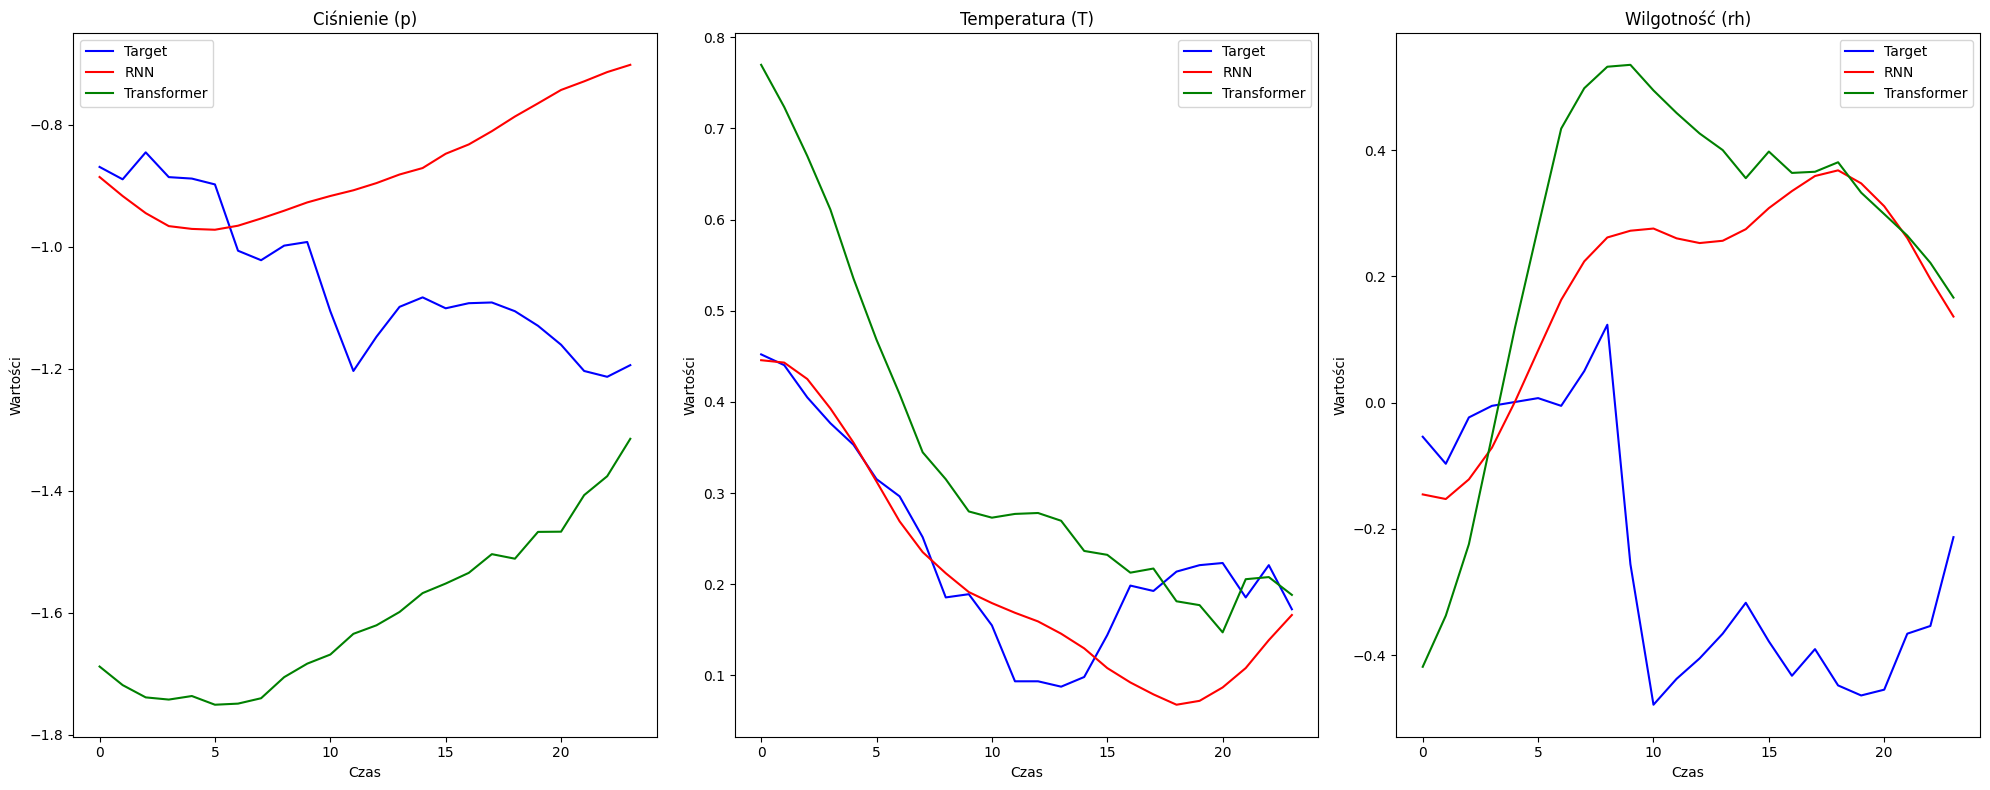

In [13]:
for i in range(5):
        
    target_pressure = targets[index[i]][:,0]  # Target p (mbar)
    target_temp = targets[index[i]][:,1]      # Target T (degC)
    target_humidity = targets[index[i]][:,2]  # Target rh (%)

    pred_rnn_pressure = pred_rnn[index[i]][:,0]
    pred_rnn_temp = pred_rnn[index[i]][:,1]
    pred_rnn_humidity = pred_rnn[index[i]][:,2]

    pred_transformer_pressure = pred_transformer[index[i]][:,0]
    pred_transformer_temp = pred_transformer[index[i]][:,1]
    pred_transformer_humidity = pred_transformer[index[i]][:,2]

    # Tworzenie wykresu
    fig, axes = plt.subplots(1, 3, figsize=(20, 8))

    # Wykres dla ciśnienia
    axes[0].set_title('Ciśnienie (p)')
    axes[0].plot(target_pressure, label='Target', color='blue')
    axes[0].plot(pred_rnn_pressure, label='RNN', color='red')
    axes[0].plot(pred_transformer_pressure, label='Transformer', color='green')

    # Wykres dla temperatury
    axes[1].set_title('Temperatura (T)')
    axes[1].plot(target_temp, label='Target', color='blue')
    axes[1].plot(pred_rnn_temp, label='RNN', color='red')
    axes[1].plot(pred_transformer_temp, label='Transformer', color='green')

    # Wykres dla wilgotności
    axes[2].set_title('Wilgotność (rh)')
    axes[2].plot(target_humidity, label='Target', color='blue')
    axes[2].plot(pred_rnn_humidity, label='RNN', color='red')
    axes[2].plot(pred_transformer_humidity, label='Transformer', color='green')

    # Ustawienie etykiet osi
    for i in range(3):
        axes[i].set_xlabel('Czas')
        axes[i].set_ylabel('Wartości')

    # Dodanie legendy do wykresów
    for i in range(3):
        axes[i].legend()

    # Dostosowanie układu
    plt.tight_layout()
    plt.show()


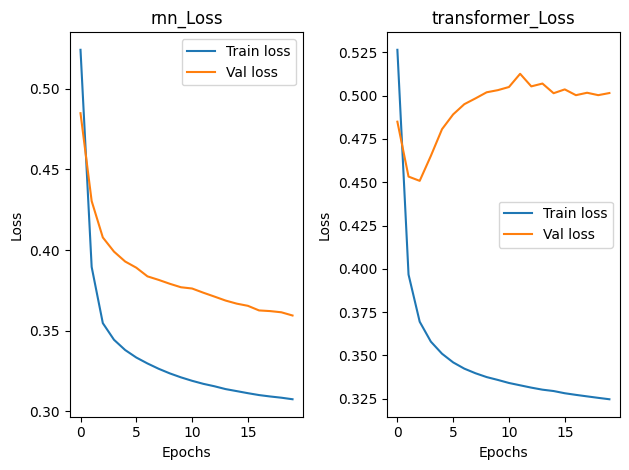

In [14]:
plt.subplot(1, 2, 1)
loss = history.history['loss']
val_loss = history.history['val_loss']
plt.title('rnn_Loss')
plt.plot(loss, label='Train loss')
plt.plot(val_loss, label='Val loss')
plt.legend()
plt.ylabel('Loss')
plt.xlabel('Epochs')

plt.subplot(1, 2, 2)
loss = history1.history['loss']
val_loss = history1.history['val_loss']
plt.title('transformer_Loss')
plt.plot(loss, label='Train loss')
plt.plot(val_loss, label='Val loss')
plt.legend()
plt.ylabel('Loss')
plt.xlabel('Epochs')


plt.xlabel('Epochs')
plt.tight_layout()
plt.show()

Nie wyglada to najlepiej dla transformera, dane z tej proby wskazuja ze 'najlepiej' radzi sobie wersja z jednym blokiem, wieksze ilosci blokow gubia kolejnosc danych, wykorzystam ta wiedze w budowaniu 2 funkcji do budowy modelu. 

In [15]:
model_rnn.save_weights('saved_models/model_rnn.weights.h5')
model.save_weights('saved_models/transformer_model_v1.weights.h5')

In [16]:
# model_rnn.load_weights('saved_models/model_rnn.weights.h5')
# model.load_weights('saved_models/transformer_model_v1.weights.h5')

In [17]:
metric_transformer_v2 = keras.metrics.R2Score()
metric_rnn_v2 = keras.metrics.R2Score()
for i in range(150):
    samples, targets = next(test_gen)
    new_shape = (targets.shape[0], targets.shape[1] * targets.shape[2])

    targets = targets.reshape(new_shape)

    pred_transformer = model.predict(samples)
    pred_transformer = pred_transformer.reshape(new_shape)
    pred_rnn = model_rnn.predict(samples)
    pred_rnn = pred_rnn.reshape(new_shape)

    metric_transformer_v2.update_state(targets, pred_transformer)
    metric_rnn_v2.update_state(targets, pred_rnn)




print(f"R^2 dla Modelu RNN: {metric_rnn_v2.result():.4f}")
print(f"R^2 dla Modelu Transformera: {metric_transformer_v2.result():.4f}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━

Obydwa modele sa przetrenowane. Na tym etapie transformer dziala duzo gorzej niz model rnn, co pokazuja wyniki R^2. Model transformera potrzebuje takrze wiecej czas do trenowania, mam nadzieje ze po dalszym tunowaniu model bedzie w stanie lepiej dostosowac sie do przewidywanych danych.

Kolejna zmiana w treningu bedzie dodanie warzonej funkcji straty, ktora zmniejszy wage dalszych prognoz, mam nadzieje ze to podejsce spowoduje lepsze dopaowania, zarowno w moddelu bazowym jak i w moelu opartym na transormerach.

In [15]:
def weighted_loss(y_true, y_pred):
    error = y_true - y_pred

    time_steps = tf.range(24, dtype=tf.float32)  
    weights = tf.exp(-time_steps / tf.constant(30.0))  

    weights = tf.expand_dims(weights, axis=-1)  
    weights = tf.expand_dims(weights, axis=0)  

    weighted_error = error * weights

    loss = tf.reduce_mean(tf.square(weighted_error))
    return loss


def build_model_for_tuning(hp):
    transformer_dim_power = hp.Int('transformer_dim_power', min_value=5, max_value=6, step=1)
    transformer_dim = 2 ** transformer_dim_power
    attention_num_heads = hp.Int('attention_num_heads', min_value=10, max_value=16, step=2)
    ffn_dim_power = hp.Int('ffn_dim_power', min_value=7, max_value=9, step=1)

    inputs = layers.Input(shape=(None, samples.shape[-1]))
    x = layers.Dense(transformer_dim)(inputs) 
    x = PositionalEncodingLayer(sequence_length=samples.shape[1], d_model=transformer_dim)(x)

    # Transformer:
    key_dim = transformer_dim 

    # Attention Layer
    attention_output = layers.MultiHeadAttention(num_heads=attention_num_heads, key_dim=key_dim)(x, x)
    attention_output = layers.Add()([x, attention_output])  # Residual connection
    attention_output = layers.Dropout(0.4)(attention_output)  
    attention_output = layers.LayerNormalization(epsilon=1e-6)(attention_output) 

    # Feed Forward Network
    ffn_output = layers.Dense(2 ** ffn_dim_power, activation="relu")(attention_output)  
    ffn_output = layers.Dense(transformer_dim)(ffn_output)  
    ffn_output = layers.Dropout(0.3)(ffn_output)  

    # Final Feed Forward + Residual Connection
    ffn_output = layers.Add()([attention_output, ffn_output]) 
    x = layers.LayerNormalization(epsilon=1e-6)(ffn_output)  # Layer Normalization

    #############

    hidden_layers_num = hp.Int('hidden_layers_num', min_value=0, max_value=3, step=1)
    hidden_layers_neurons_pow = hp.Int('hidden_layers_neurons_pow', min_value=6, max_value=9, step=1)
    hidden_layers_activation = hp.Choice('hidden_layers_activation', ['relu', 'swish']) 
    hidden_layers_dropout = hp.Float('hidden_layers_dropout', min_value=0.0, max_value=0.5, step=0.1)

    x = layers.GlobalAveragePooling1D()(x)
    for _ in range(hidden_layers_num):
        x = layers.Dense(2 ** hidden_layers_neurons_pow, activation=hidden_layers_activation)(x)
        x = layers.Dropout(hidden_layers_dropout)(x)

    outputs = layers.Dense((delay // t_step) * 3)(x)        # Formatting output
    outputs = layers.Reshape((delay // t_step, 3))(outputs) 

    # Optimizer
    base_lr = hp.Float('learning_rate', min_value=1e-5, max_value=1e-2, sampling="log")
    beta_1 = hp.Float('beta_1', min_value=0.85, max_value=0.99, step=0.01)
    beta_2 = hp.Float('beta_2', min_value=0.85, max_value=0.999, step=0.01)
    optimizer = Adam(learning_rate=base_lr, beta_1=beta_1, beta_2=beta_2)
    
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=optimizer, loss=weighted_loss)

    return model

In [16]:
from tensorflow.keras.callbacks import EarlyStopping


tuner1 = kt.BayesianOptimization(
        build_model_for_tuning,
        objective='val_loss',
        max_trials=50,  # Maksymalna liczba prób
        executions_per_trial=1, 
        directory='my_dir',
        project_name='final_model_bayes'
    )

early_stopping = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)

# Użycie tunera
tuner1.search(
    train_gen,
    epochs=50,  
    validation_data=val_gen,
    steps_per_epoch=train_steps,
    validation_steps=val_steps,
    callbacks=[early_stopping]  # Callbacki
)

Reloading Tuner from my_dir/final_model_bayes/tuner0.json


In [18]:
best_hps = tuner1.get_best_hyperparameters(num_trials=3)
model_v2 = build_model_for_tuning(best_hps[0])

model_v2.summary()
history1_v2 = model_v2.fit(train_gen,
    epochs=50,  
    validation_data=val_gen,
    steps_per_epoch=train_steps,
    validation_steps=val_steps,
    callbacks=[early_stopping])

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, None, 5)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, None, 32)  │        192 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ positional_encodin… │ (None, None, 32)  │          0 │ dense_1[0][0]     │
│ (PositionalEncodin… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, None, 32)  │     41,952 │ positional_encod… │
│ (MultiHeadAttentio… │                   │            │ positional_encod… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, None, 32)  │          0 │ positional_encod… │
│                     │                   │            │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, None, 32)  │          0 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, None, 32)  │         64 │ dropout_1[0][0]   │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, None, 512) │     16,896 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, None, 32)  │     16,416 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, None, 32)  │          0 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, None, 32)  │          0 │ layer_normalizat… │
│                     │                   │            │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, None, 32)  │         64 │ add_1[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 32)        │          0 │ layer_normalizat… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 64)        │      2,112 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 64)        │          0 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 64)        │      4,160 │ dropout_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 64)        │          0 │ dense_5[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 72)        │      4,680 │ dropout_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_1 (Reshape) │ (None, 24, 3)     │          0 │ dense_6[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 86,536 (338.03 KB)

 Trainable params: 86,536 (338.03 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50


I0000 00:00:1737977896.867627  138458 service.cc:148] XLA service 0x750010015100 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1737977896.867653  138458 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2025-01-27 12:38:16.929845: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1737977897.152075  138458 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-01-27 12:38:17.852530: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_30', 8 bytes spill stores, 8 bytes spill loads

2025-01-27 12:38:17.978340: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_30', 16 bytes spill

  13/2574 ━━━━━━━━━━━━━━━━━━━━ 35s 14ms/step - loss: 1.2768

I0000 00:00:1737977904.228204  138458 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2574/2574 ━━━━━━━━━━━━━━━━━━━━ 46s 15ms/step - loss: 0.4391 - val_loss: 0.2611
Epoch 2/50
2574/2574 ━━━━━━━━━━━━━━━━━━━━ 37s 14ms/step - loss: 0.2560 - val_loss: 0.1850
Epoch 3/50
2574/2574 ━━━━━━━━━━━━━━━━━━━━ 36s 14ms/step - loss: 0.1878 - val_loss: 0.1520
Epoch 4/50
2574/2574 ━━━━━━━━━━━━━━━━━━━━ 36s 14ms/step - loss: 0.1534 - val_loss: 0.1295
Epoch 5/50
2574/2574 ━━━━━━━━━━━━━━━━━━━━ 36s 14ms/step - loss: 0.1351 - val_loss: 0.1224
Epoch 6/50
2574/2574 ━━━━━━━━━━━━━━━━━━━━ 36s 14ms/step - loss: 0.1269 - val_loss: 0.1189
Epoch 7/50
2574/2574 ━━━━━━━━━━━━━━━━━━━━ 36s 14ms/step - loss: 0.1221 - val_loss: 0.1182
Epoch 8/50
2574/2574 ━━━━━━━━━━━━━━━━━━━━ 37s 14ms/step - loss: 0.1191 - val_loss: 0.1161
Epoch 9/50
2574/2574 ━━━━━━━━━━━━━━━━━━━━ 36s 14ms/step - loss: 0.1166 - val_loss: 0.1156
Epoch 10/50
2574/2574 ━━━━━━━━━━━━━━━━━━━━ 35s 14ms/step - loss: 0.1152 - val_loss: 0.1138
Epoch 11/50
2574/2574 ━━━━━━━━━━━━━━━━━━━━ 35s 14ms/step - loss: 0.1140 - val_loss: 0.1136
Epoch 12/50
2574/25

In [21]:
model_rnn_v2 = models.Sequential()
model_rnn_v2.add(layers.LSTM(32, return_sequences=True, input_shape=(None, samples.shape[-1])))
model_rnn_v2.add(layers.LSTM(16))
model_rnn_v2.add(layers.Dense((delay // t_step) * 3)) 
model_rnn_v2.add(layers.Reshape((delay // t_step, 3))) 

model_rnn_v2.compile(optimizer='adam', loss=weighted_loss)

history_v2 = model_rnn_v2.fit(train_gen,
                    steps_per_epoch=train_steps,
                    epochs=20,
                    validation_data=val_gen,
                    validation_steps=val_steps)

Epoch 1/20
2574/2574 ━━━━━━━━━━━━━━━━━━━━ 23s 9ms/step - loss: 0.3215 - val_loss: 0.1985
Epoch 2/20
2574/2574 ━━━━━━━━━━━━━━━━━━━━ 23s 9ms/step - loss: 0.1309 - val_loss: 0.1392
Epoch 3/20
2574/2574 ━━━━━━━━━━━━━━━━━━━━ 22s 8ms/step - loss: 0.1071 - val_loss: 0.1381
Epoch 4/20
2574/2574 ━━━━━━━━━━━━━━━━━━━━ 22s 8ms/step - loss: 0.1014 - val_loss: 0.1301
Epoch 5/20
2574/2574 ━━━━━━━━━━━━━━━━━━━━ 22s 9ms/step - loss: 0.0970 - val_loss: 0.1268
Epoch 6/20
2574/2574 ━━━━━━━━━━━━━━━━━━━━ 21s 8ms/step - loss: 0.0951 - val_loss: 0.1222
Epoch 7/20
2574/2574 ━━━━━━━━━━━━━━━━━━━━ 21s 8ms/step - loss: 0.0928 - val_loss: 0.1197
Epoch 8/20
2574/2574 ━━━━━━━━━━━━━━━━━━━━ 21s 8ms/step - loss: 0.0912 - val_loss: 0.1170
Epoch 9/20
2574/2574 ━━━━━━━━━━━━━━━━━━━━ 21s 8ms/step - loss: 0.0899 - val_loss: 0.1161
Epoch 10/20
2574/2574 ━━━━━━━━━━━━━━━━━━━━ 22s 8ms/step - loss: 0.0892 - val_loss: 0.1150
Epoch 11/20
2574/2574 ━━━━━━━━━━━━━━━━━━━━ 21s 8ms/step - loss: 0.0883 - val_loss: 0.1137
Epoch 12/20
2574/25

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


2025-01-26 17:42:44.154928: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_8_0', 56 bytes spill stores, 56 bytes spill loads



4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


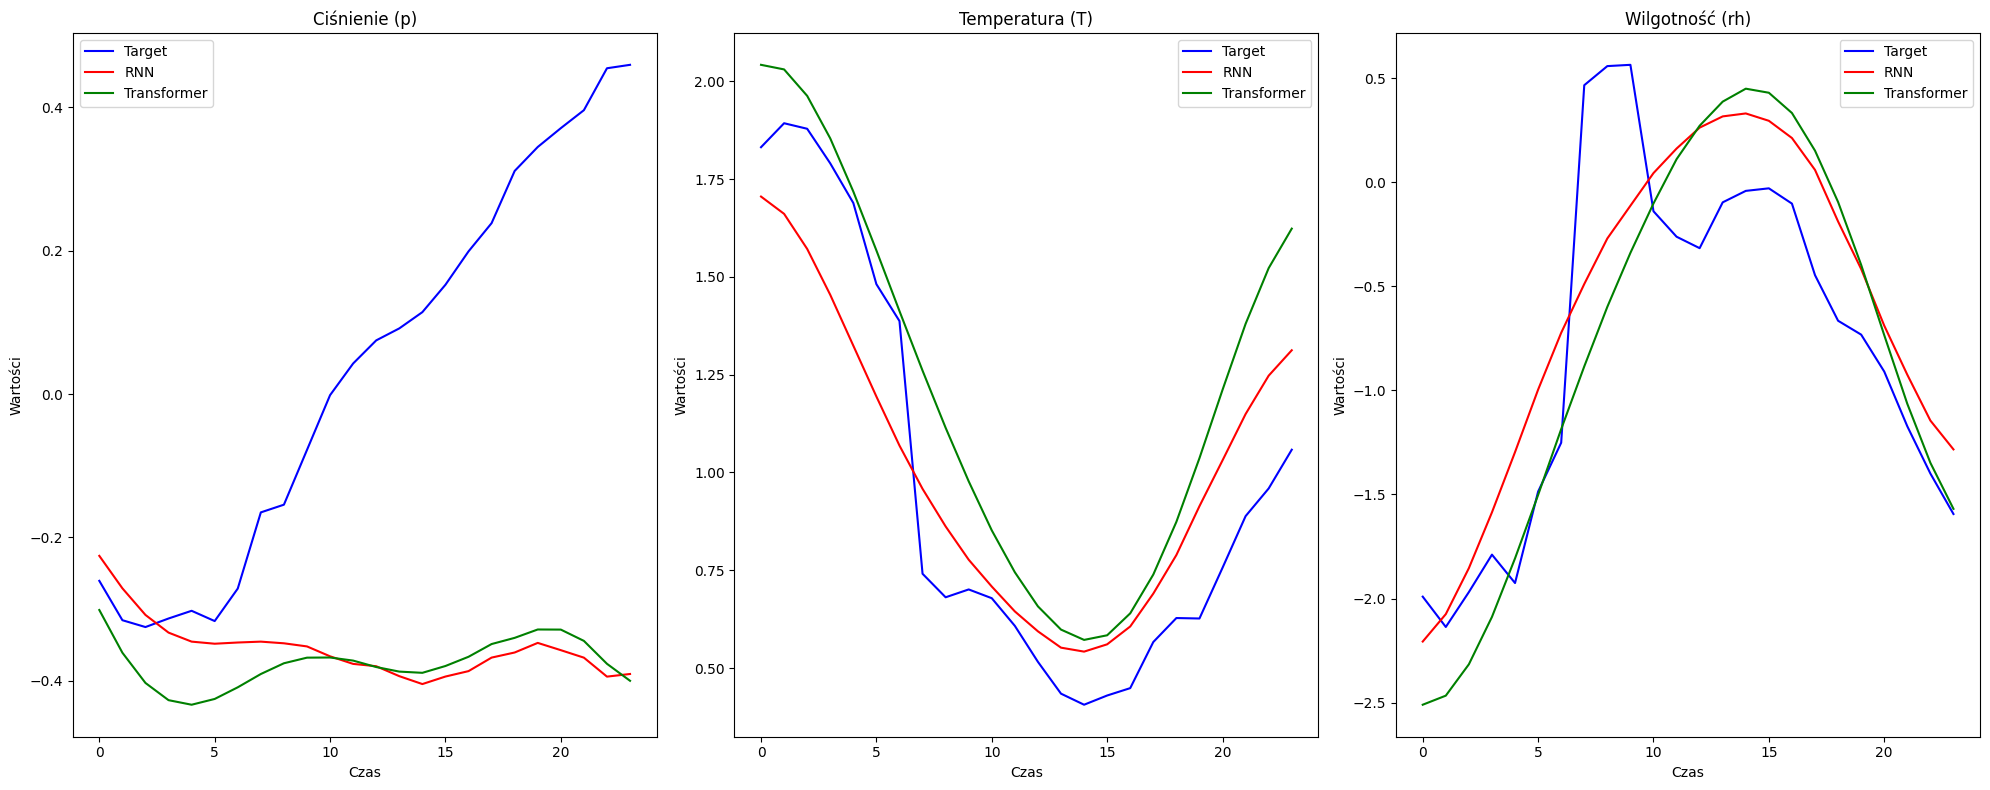

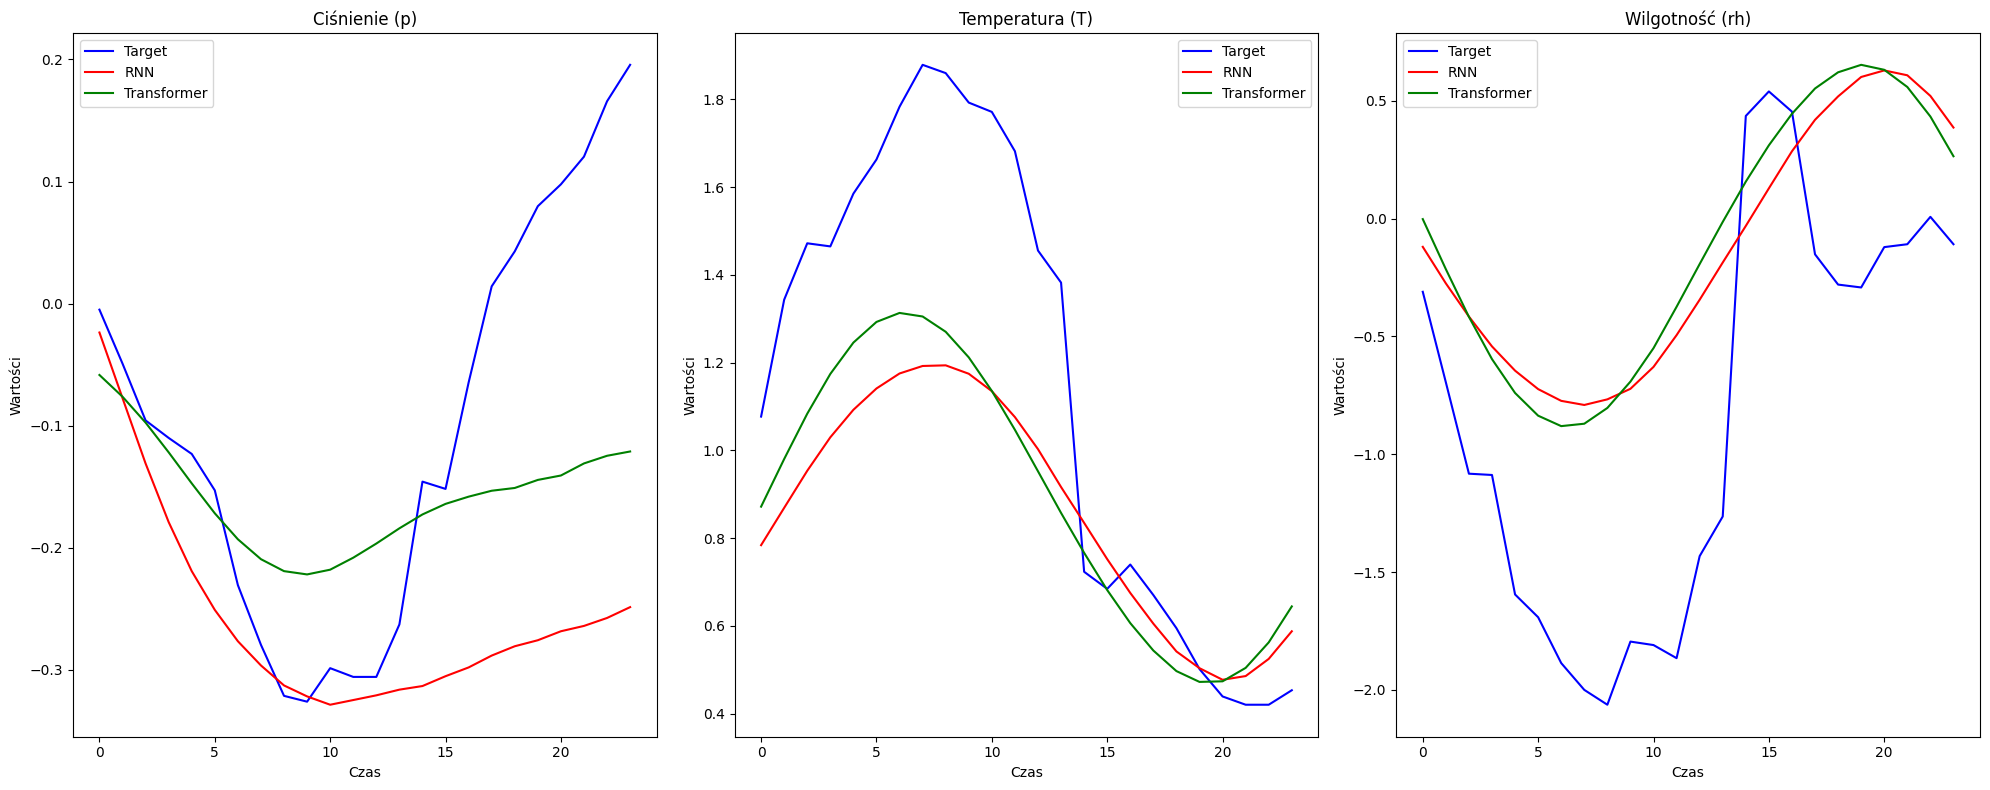

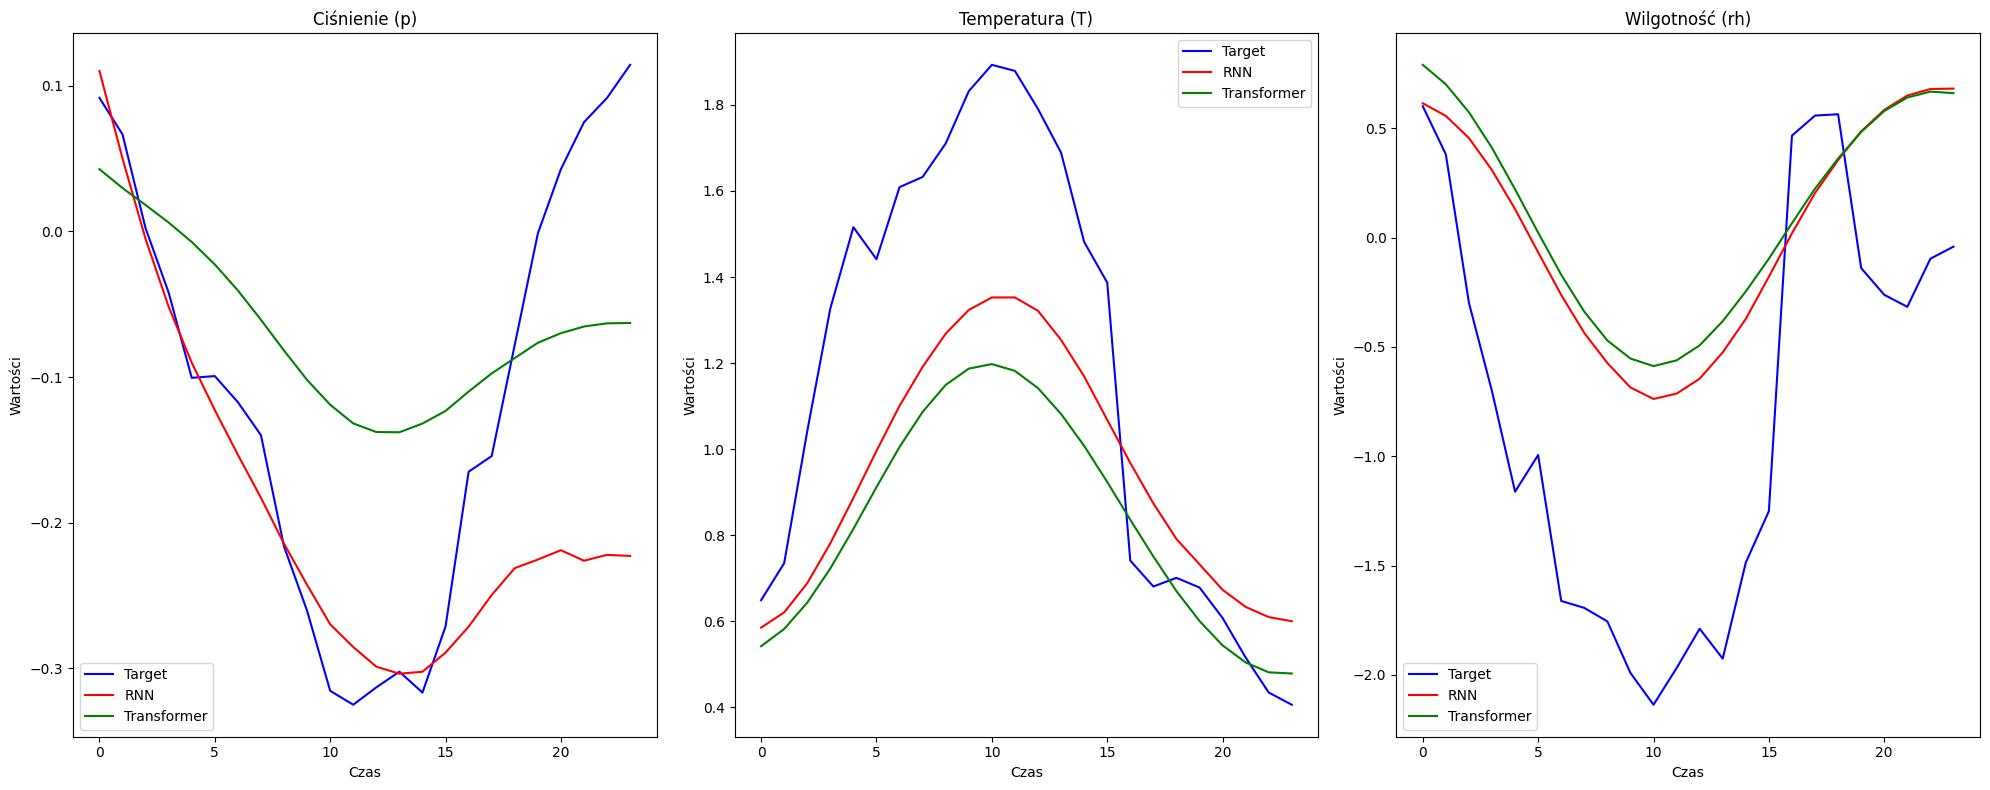

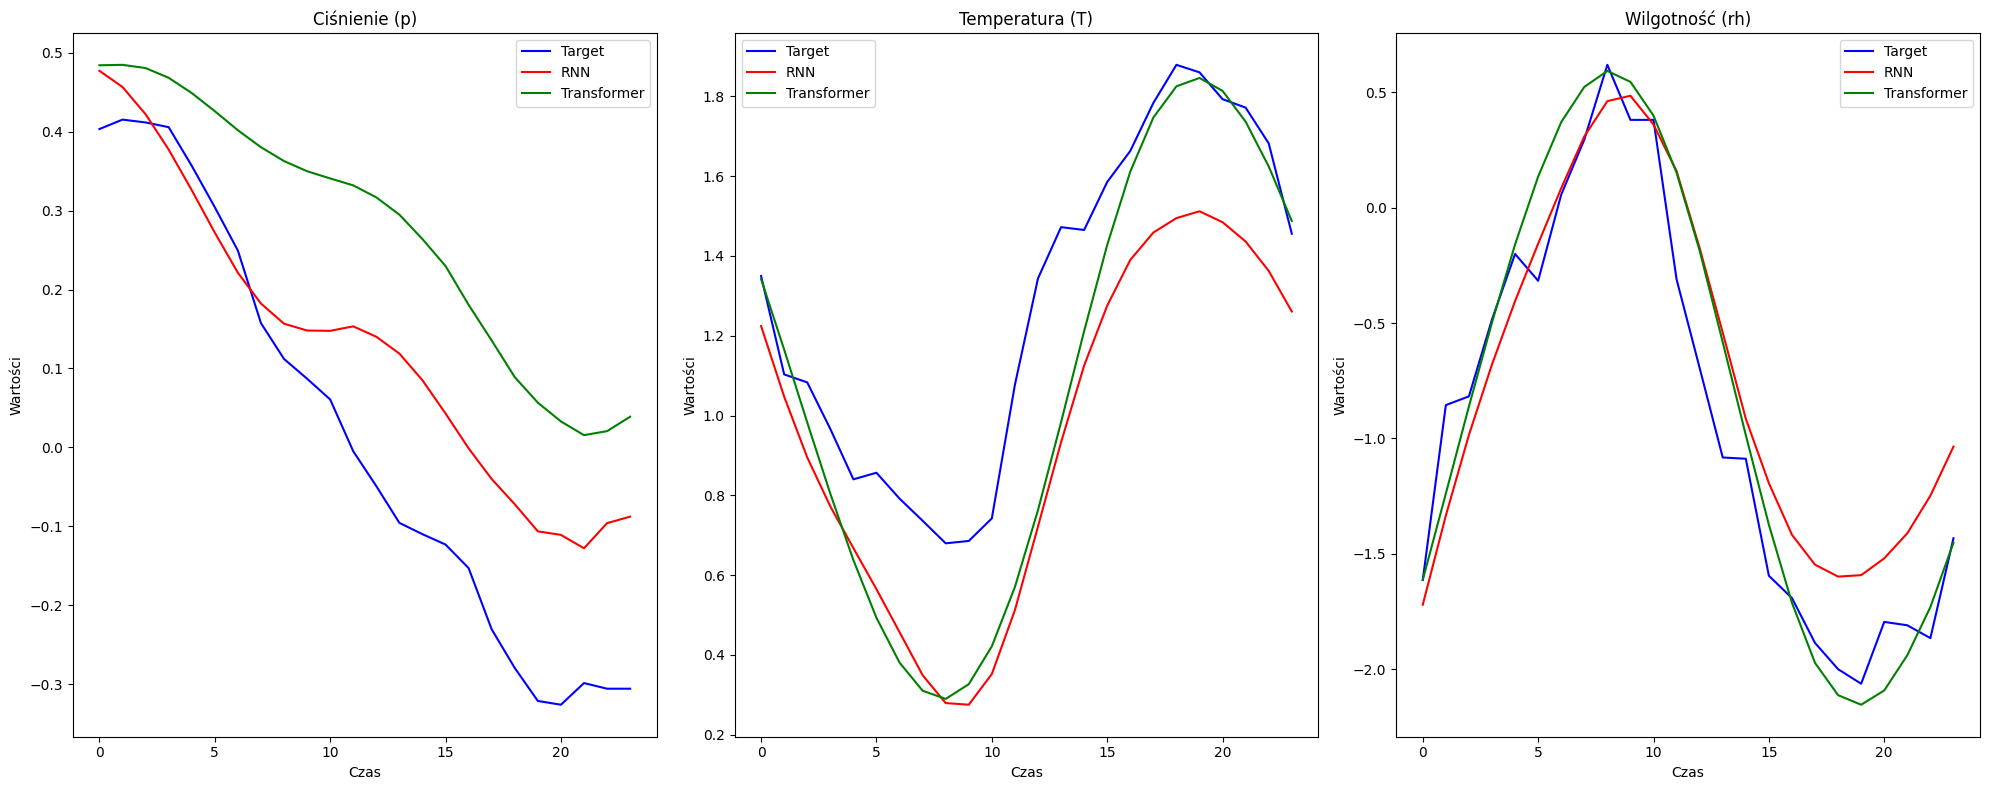

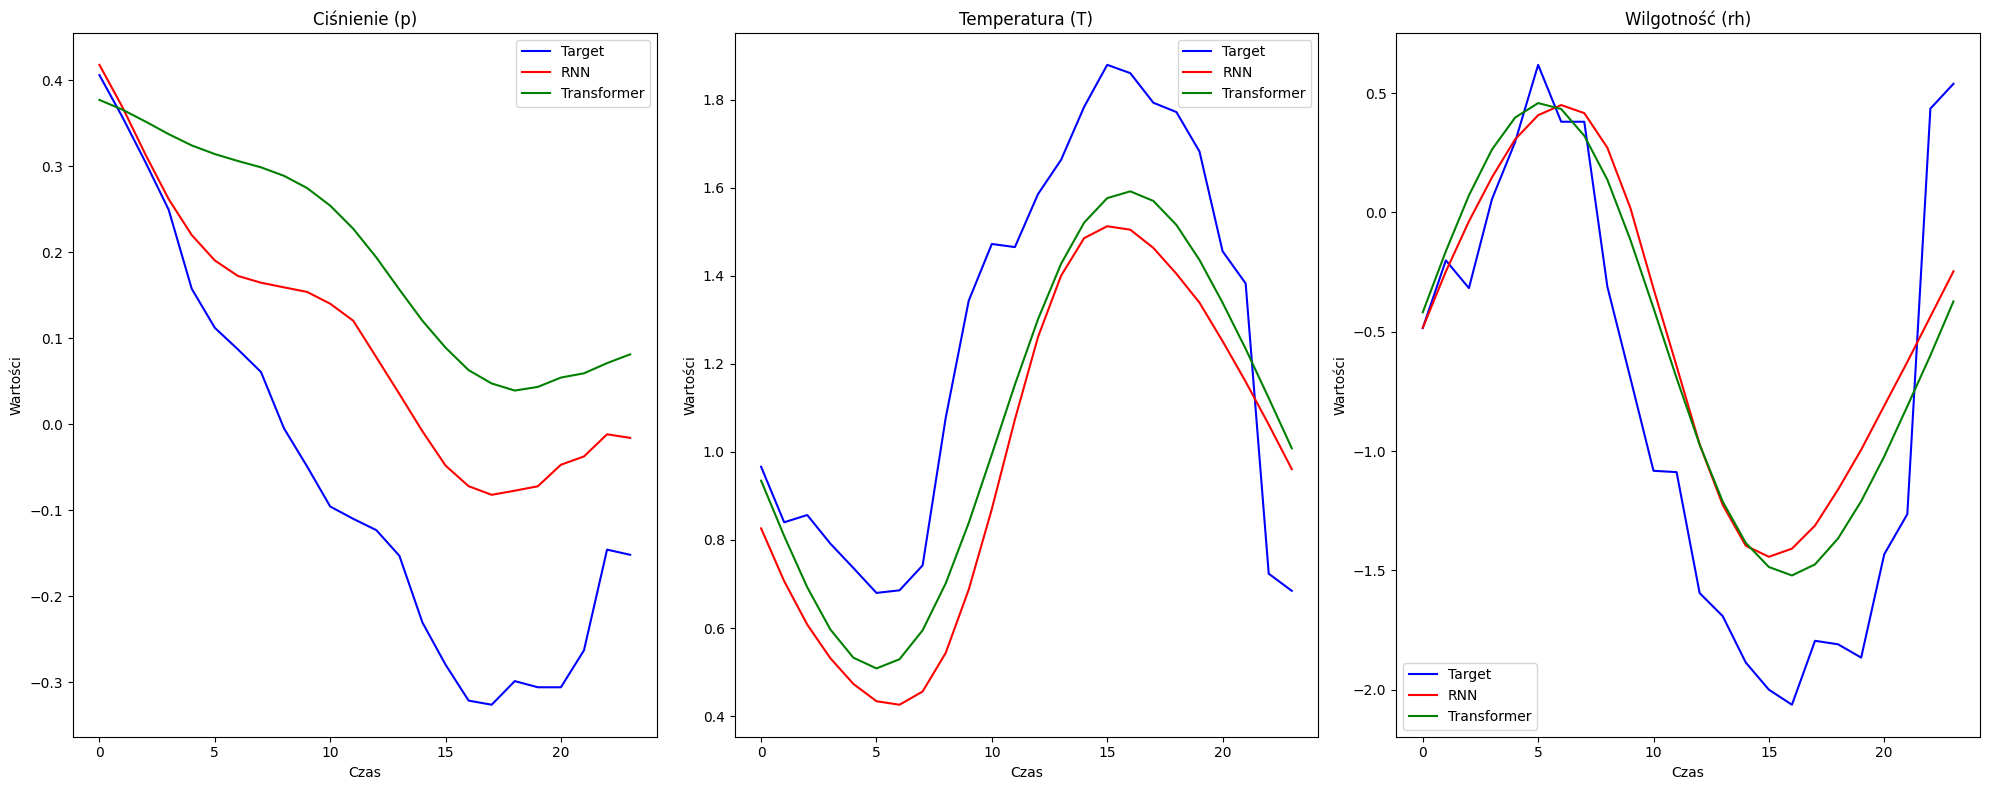

In [22]:
samples, targets = next(test_gen)

# Uzyskanie przewidywań z obu modeli
pred_rnn = model_rnn_v2.predict(samples)
pred_transformer = model_v2.predict(samples)

index = [123, 82, 69, 16, 34]
for i in range(5):
        
    target_pressure = targets[index[i]][:,0]  # Target p (mbar)
    target_temp = targets[index[i]][:,1]      # Target T (degC)
    target_humidity = targets[index[i]][:,2]  # Target rh (%)

    pred_rnn_pressure = pred_rnn[index[i]][:,0]
    pred_rnn_temp = pred_rnn[index[i]][:,1]
    pred_rnn_humidity = pred_rnn[index[i]][:,2]

    pred_transformer_pressure = pred_transformer[index[i]][:,0]
    pred_transformer_temp = pred_transformer[index[i]][:,1]
    pred_transformer_humidity = pred_transformer[index[i]][:,2]

    # Tworzenie wykresu
    fig, axes = plt.subplots(1, 3, figsize=(20, 8))

    # Wykres dla ciśnienia
    axes[0].set_title('Ciśnienie (p)')
    axes[0].plot(target_pressure, label='Target', color='blue')
    axes[0].plot(pred_rnn_pressure, label='RNN', color='red')
    axes[0].plot(pred_transformer_pressure, label='Transformer', color='green')

    # Wykres dla temperatury
    axes[1].set_title('Temperatura (T)')
    axes[1].plot(target_temp, label='Target', color='blue')
    axes[1].plot(pred_rnn_temp, label='RNN', color='red')
    axes[1].plot(pred_transformer_temp, label='Transformer', color='green')

    # Wykres dla wilgotności
    axes[2].set_title('Wilgotność (rh)')
    axes[2].plot(target_humidity, label='Target', color='blue')
    axes[2].plot(pred_rnn_humidity, label='RNN', color='red')
    axes[2].plot(pred_transformer_humidity, label='Transformer', color='green')

    # Ustawienie etykiet osi
    for i in range(3):
        axes[i].set_xlabel('Czas')
        axes[i].set_ylabel('Wartości')

    # Dodanie legendy do wykresów
    for i in range(3):
        axes[i].legend()

    # Dostosowanie układu
    plt.tight_layout()
    plt.show()

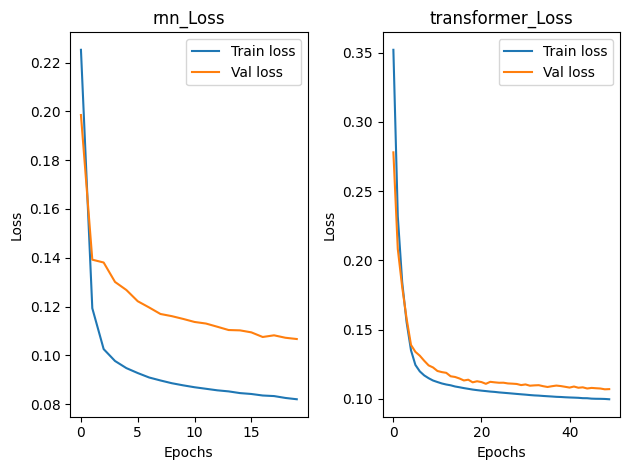

In [30]:
plt.subplot(1, 2, 1)
loss = history_v2.history['loss']
val_loss = history_v2.history['val_loss']
plt.title('rnn_Loss')
plt.plot(loss, label='Train loss')
plt.plot(val_loss, label='Val loss')
plt.legend()
plt.ylabel('Loss')
plt.xlabel('Epochs')

plt.subplot(1, 2, 2)
loss = history1_v2.history['loss']
val_loss = history1_v2.history['val_loss']
plt.title('transformer_Loss')
plt.plot(loss, label='Train loss')
plt.plot(val_loss, label='Val loss')
plt.legend()
plt.ylabel('Loss')
plt.xlabel('Epochs')


plt.xlabel('Epochs')
plt.tight_layout()
plt.show()

Model transformera jest o wiele mniej przeuczony, jednak dokladnosc modeli jest bardzo podobna.

In [20]:
metric_transformer_v2 = keras.metrics.R2Score()
metric_rnn_v2 = keras.metrics.R2Score()
for i in range(150):
    samples, targets = next(test_gen)
    new_shape = (targets.shape[0], targets.shape[1] * targets.shape[2])

    targets = targets.reshape(new_shape)

    pred_transformer = model_v2.predict(samples)
    pred_transformer = pred_transformer.reshape(new_shape)
    pred_rnn = model_rnn_v2.predict(samples)
    pred_rnn = pred_rnn.reshape(new_shape)

    metric_transformer_v2.update_state(targets, pred_transformer)
    metric_rnn_v2.update_state(targets, pred_rnn)




print(f"R^2 dla Modelu RNN: {metric_rnn_v2.result():.4f}")
print(f"R^2 dla Modelu Transformera: {metric_transformer_v2.result():.4f}")

2025-01-27 13:02:41.862038: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_11', 16 bytes spill stores, 16 bytes spill loads

2025-01-27 13:02:42.160279: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_8_0', 56 bytes spill stores, 56 bytes spill loads

2025-01-27 13:02:42.163543: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_11', 8 bytes spill stores, 8 bytes spill loads



4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━

In [19]:
model_rnn_v2.save_weights('saved_models/model_rnn_v2.weights.h5')
model_v2.save_weights('saved_models/transformer_model_v2.weights.h5')

In [12]:
model_rnn_v2.load_weights('saved_models/model_rnn_v2.weights.h5')
model_v2 = build_model_for_tuning(tuner1.get_best_hyperparameters(3)[0])
model_v2.load_weights('saved_models/transformer_model_v2.weights.h5')

Uzyskane dane wskazuja ze model transformera jest nieco lepszy od modelu rnn, w trenowaniu obu moeli najwieksza poprawe wniosla zmiana funkcji straty.
Teraz pozostaje mi zastosowac model do prognozowania pogody, biorac pod uwage czas, poswiecony na fitowanie transformera model rnn pozostaje lepszy w prognozowaniu pogody

In [28]:
def denormalize_data(pred_data):
    array_shape = (pred_data[0].shape[0], pred_data[0].shape[1])
    denormalized_data = np.zeros(array_shape) 
    for i in range(array_shape[0]):
        denormalized_data[i][0] = pred_data[0][i][0] * data_std[0] + data_mean[0]
        denormalized_data[i][1] = pred_data[0][i][1] * data_std[1] + data_mean[1]
        denormalized_data[i][2] = pred_data[0][i][2] * data_std[4] + data_mean[4]
    return denormalized_data


2025-01-27 13:03:43.752968: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_15', 16 bytes spill stores, 16 bytes spill loads

2025-01-27 13:03:43.974803: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_10', 8 bytes spill stores, 8 bytes spill loads

2025-01-27 13:03:44.263502: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_10', 404 bytes spill stores, 404 bytes spill loads



1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


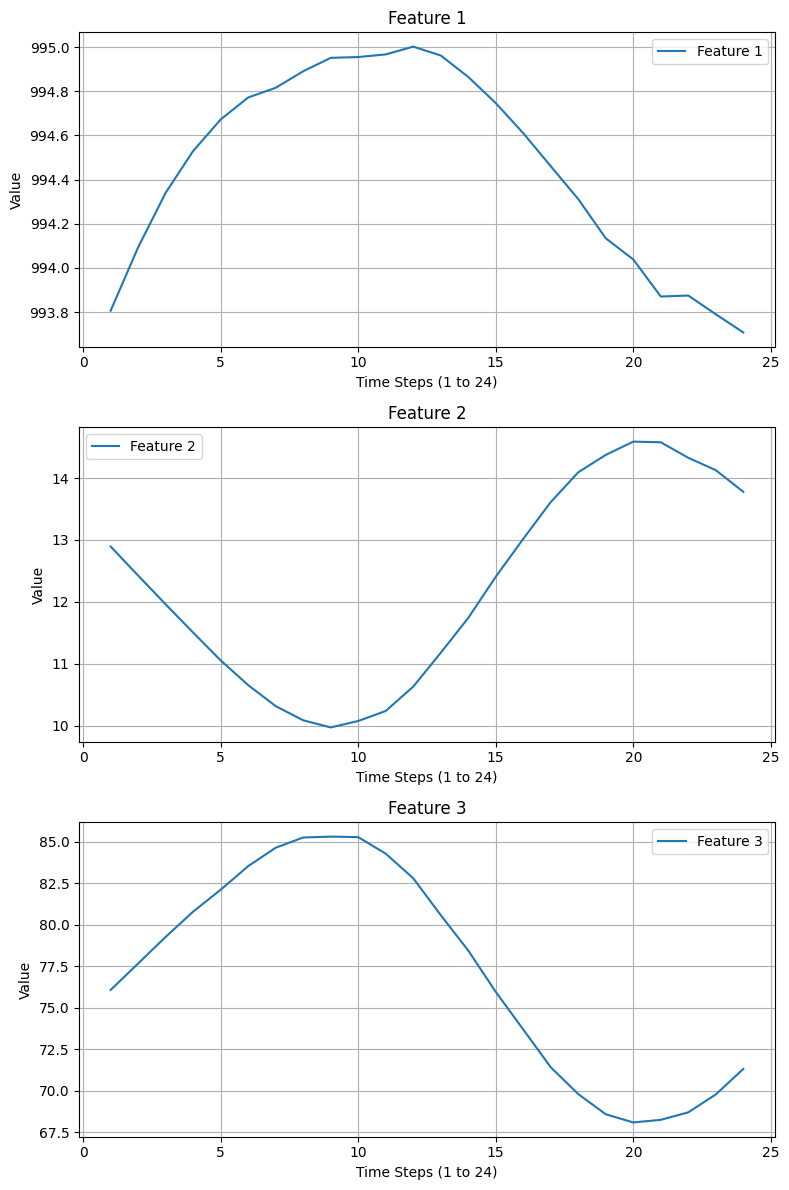

In [22]:
sample = tf.expand_dims(samples[0], axis=0)
pred_data = model_v2.predict(sample)
p_data = denormalize_data(pred_data)

fig, axs = plt.subplots(3, 1, figsize=(8, 12))  # 3 wiersze, 1 kolumna

# Oś X (1 do 24)
x = np.arange(1, 25)

# Pętla do tworzenia wykresów dla każdej z 3 kolumn
for i in range(3):
    axs[i].plot(x, p_data[:, i], label=f'Feature {i+1}')
    axs[i].set_title(f'Feature {i+1}')
    axs[i].set_xlabel('Time Steps (1 to 24)')
    axs[i].set_ylabel('Value')
    axs[i].grid(True)
    axs[i].legend()

# Dopasowanie rozmiaru wykresów
plt.tight_layout()
plt.show()

In [29]:
def plot_weather_chcarts(sample):
    h_data_targets = np.arange(-71, 1)
    h_data_preds = np.arange(1, 25)

    # Przetworzenie danych
    pred_data = model_v2.predict(sample)
    p_data = denormalize_data(pred_data)

    targets_data = denormalize_data(sample)
    display_targets_data = targets_data[::2] 

    # Tworzenie wykresów
    fig, axs = plt.subplots(3, 1, figsize=(8, 12))  
    colors = ['red', 'green' ,'orange']
    values = ['P (mbar)', 'T (°C)', 'HR (%)']
    labels = ['Pressure', 'Temperature', 'Humidity']
    for i in range(3):
        axs[i].plot(h_data_targets, display_targets_data[:, i], label='Targets', color='blue')
        axs[i].plot(h_data_preds, p_data[:, i], label='Predictions', color=colors[i], linestyle='dashed')
        axs[i].set_title(labels[i])
        axs[i].set_xlabel('Time (h)')
        axs[i].set_ylabel(values[i])
        axs[i].grid(True)
        axs[i].legend()

        axs[i].set_xlim(-71, 24)
        xticks = np.arange(-72, 25, 6) 
        axs[i].set_xticks(xticks)

    plt.tight_layout()
    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


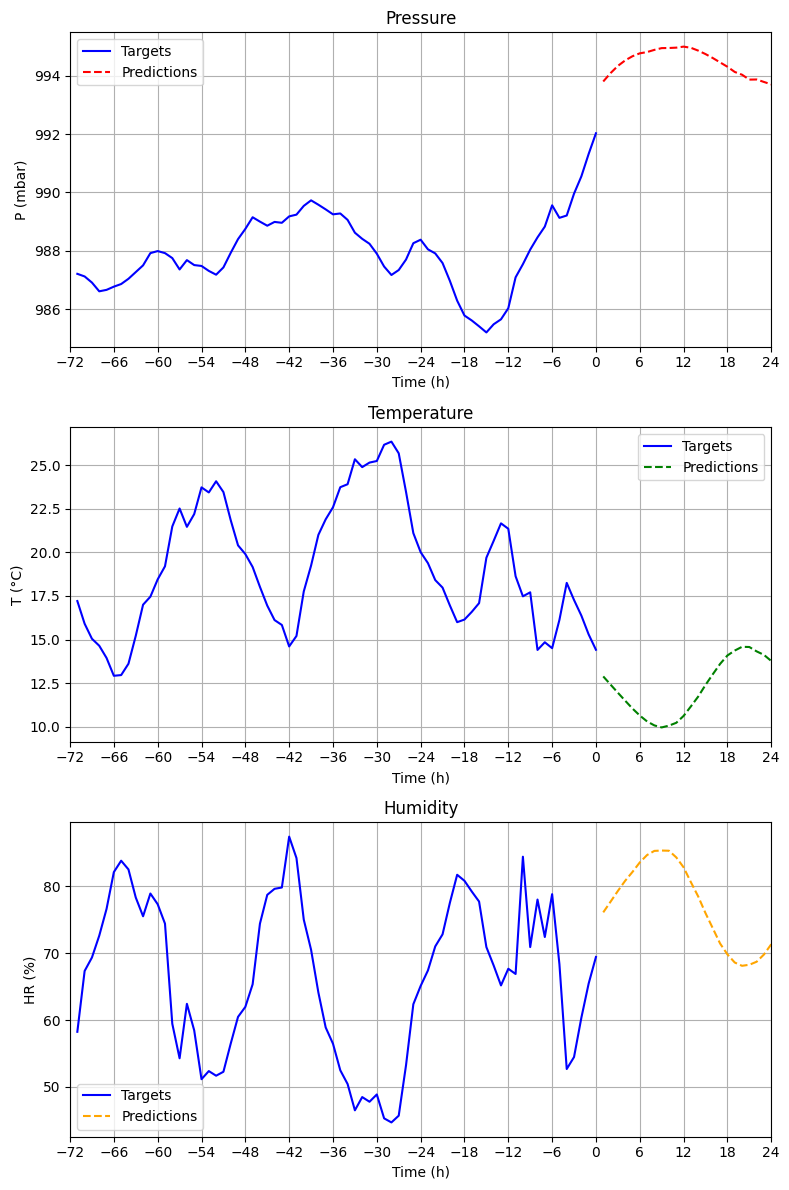

In [24]:
sample = tf.expand_dims(samples[0], axis=0)
plot_weather_chcarts(sample)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


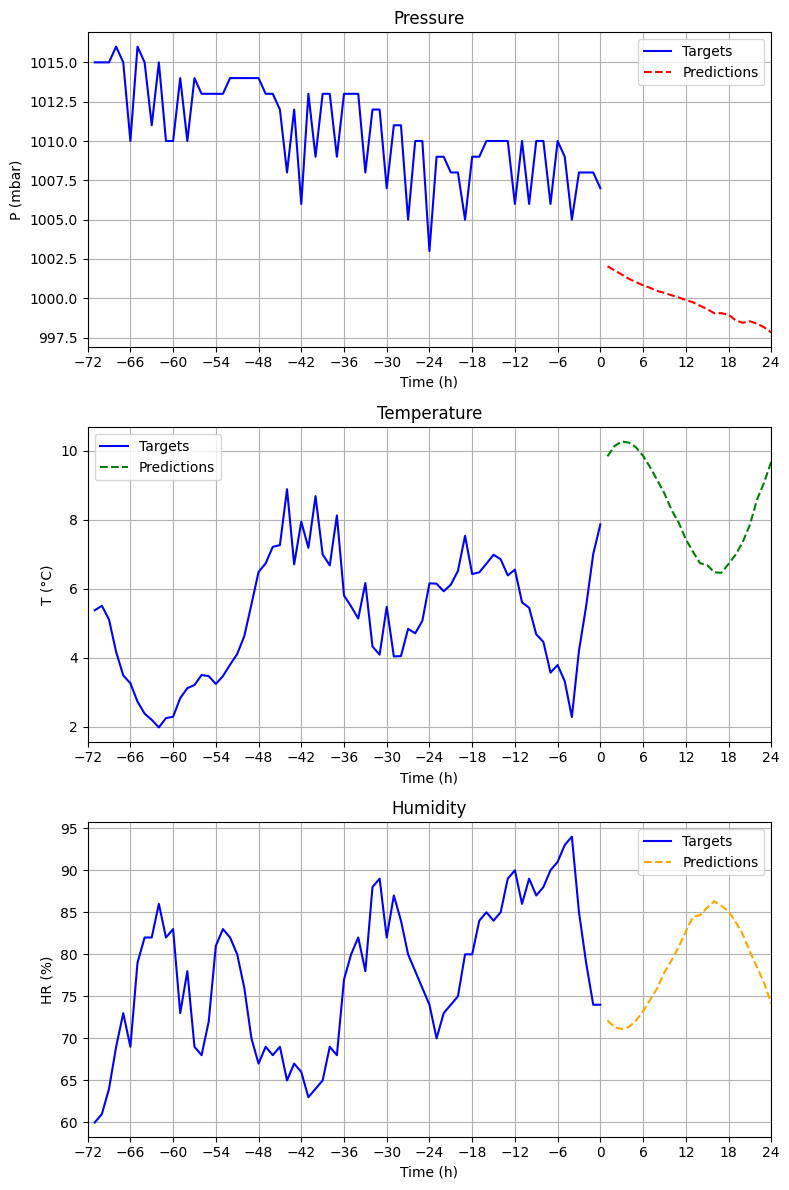

In [ ]:
import requests
from datetime import datetime, timedelta
import json
#api nie ma VPmax dlatego licze je ze wzoru na jego przyblirzenie, wplynie to niestety na dokladnosc i skoreluje dane z temperatura
# VPmax = 6.11 * 10 ** ((7.5 * T) / (T + 237.3)) gdzie T to Temperatura

API_KEY = 'API_KEY'  

latitude = 52.2297  # Warszawa
longitude = 21.0122
url = "https://api.openweathermap.org/data/3.0/onecall/timemachine"

now = datetime.utcnow().replace(minute=0, second=0, microsecond=0)
start_time = now - timedelta(days=3)  # 3 dni temu
interval = timedelta(minutes=30)  # 30 minut
weather_data = []

current_time = start_time
for _ in range(144):
    unix_timestamp = int(current_time.timestamp()) 

    params = {
        'lat': latitude,
        'lon': longitude,
        'dt': unix_timestamp,
        'appid': API_KEY,
        'units': 'metric',  
    }
    response = requests.get(url, params=params)

    if response.status_code == 200:
        data = response.json()
        for data_point in data.get('data', []):
            weather_data.append({
                'P (mbar)': data_point['pressure'],
                'T (degC)': data_point['temp'],
                'RH (%)': data_point['humidity'],
                'Tdew (degC)': data_point['dew_point'],
                'VPmax (mbar)': 6.11 * 10 ** ((7.5 * data_point['temp']) / (data_point['temp'] + 237.3))
            })
    current_time += interval

weather_df = pd.DataFrame(weather_data)
weather_sample = weather_df.values

for i in range(144):
    weather_sample[i][0] = (weather_sample[i][0] - data_mean[0]) / data_std[0]
    weather_sample[i][1] = (weather_sample[i][1] - data_mean[1]) / data_std[1]
    weather_sample[i][2] = (weather_sample[i][2] - data_mean[4]) / data_std[4]
    weather_sample[i][3] = (weather_sample[i][3] - data_mean[3]) / data_std[3]
    weather_sample[i][4] = (weather_sample[i][4] - data_mean[5]) / data_std[5]

weather_sample = tf.expand_dims(weather_sample, axis=0)
plot_weather_chcarts(weather_sample)